# IMPORT PACKAGES

In [19]:
import pandas as pd
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
pd.core.common.is_list_like = pd.api.types.is_list_like
from pandas_datareader import data as wb
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from datetime import *
from math import log, sqrt
import statsmodels.api as sm
import time
import csv
from pandas import DataFrame
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.seasonal import *
import requests as res

# FUNCTIONS

In [20]:
# . . . . . . . . . . . . . . . . . . . Display as a percentage . . . . . . . . . . . . . . . . . . . 
def display_as_percentage(val):
    return '{:.1f}%'.format(val * 100)


# . . . . . . . . . . . . . . . . . . . Simple Rate Of Return . . . . . . . . . . . . . . . . . . . 
def calculate_simple_return(start_price, end_price, dividend=0):
    return (end_price - start_price + dividend) / start_price
        # ADD THE BELOW TO PRODUCT THE SIMPLE RATE OF RETURN 
        # simple_return = calculate_simple_return(100, 150, 10)
        #print('The simple rate of return is', display_as_percentage(simple_return))
    

# . . . . . . . . . . . . . . . . . . . Logarithmic Rate of Return . . . . . . . . . . . . . . . . . . . 
def calculate_log_return(start_price, end_price):
    return log(end_price)-log(start_price)
        # ADD THE BELOW TO PRODUCT THE SIMPLE RATE OF RETURN 
        # log_return=calculate_log_return(200,250)
        # print(display_as_percentage(log_return))
        

# . . . . . . . . . . . . . . . . . . . Annual Rate of Return . . . . . . . . . . . . . . . . . . . 
def annualize_return(log_return, t):
    return log_return*t
        # ADD THE BELOW TO PRODUCT THE SIMPLE RATE OF RETURN 
        # annual_return_a=annualize_return(daily_return_a,252)
        # print('The annual rate of return for Investment A is '+str(display_as_percentage(annual_return_a))+'%')
        # annual_return_b=annualize_return(monthly_return_b,12)
        # print('The annual rate of return for Investment B is '+str(display_as_percentage(annual_return_b))+'%')


# . . . . . . . . . . . . . . . . . . . Convert Log Returns to Daily/Weekly/Monthly/Annual Returns: . . . . . . . . . . . . . . . . . . . 
def convert_returns(log_returns, t):
    return (sum(log_returns) / len(log_returns)) * t
        # ADD THE BELOW TO PRODUCT THE SIMPLE RATE OF RETURN 
        # annual_return = convert_returns(daily_returns, 252)
        # print('The annual rate of return is', display_as_percentage(annual_return))
        # weekly_return = convert_returns(daily_returns, 5)
        # weekly_return = sum(daily_returns)
        # print('The weekly rate of return is', display_as_percentage(weekly_return))


# . . . . . . . . . . . . . . . . . . . Variance . . . . . . . . . . . . . . . . . . . 
def calculate_variance(dataset):
    mean = sum(dataset) / len(dataset)
    numerator = 0
    for data in dataset:
        numerator += (data - mean) ** 2
    variance = numerator / len(dataset)
    return variance
        # ADD THE BELOW TO PRODUCT THE SIMPLE RATE OF RETURN 
        # variance_disney = calculate_variance(returns_disney)
        # variance_cbs = calculate_variance(returns_cbs)
        # print('The variance of Disney stock returns is', variance_disney)
        # print('The variance of CBS stock returns is', variance_cbs)


# . . . . . . . . . . . . . . . . . . . Standard Deviation . . . . . . . . . . . . . . . . . . . 
def calculate_stddev(dataset):
    variance = calculate_variance(dataset)
    stddev = sqrt(variance)
    return stddev
        # ADD THE BELOW TO PRODUCT THE SIMPLE RATE OF RETURN 
        # stddev_disney = calculate_stddev(returns_disney)
        # stddev_cbs = calculate_stddev(returns_cbs)
        # print('The standard deviation of Disney stock returns is', display_as_percentage(stddev_disney))
        # print('The standard deviation of CBS stock returns is', display_as_percentage(stddev_cbs))

        
# . . . . . . . . . . . . . . . . . . . Calculate Correlation among Assets . . . . . . . . . . . . . . . . . . . 
def calculate_correlation(set_x, set_y):
  # Sum of all values in each dataset
    sum_x = sum(set_x)
    sum_y = sum(set_y)
  # Sum of all squared values in each dataset   
    sum_x2 = sum([x ** 2 for x in set_x])
    sum_y2 = sum([y ** 2 for y in set_y])
  # Sum of the product of each respective element in each dataset 
    sum_xy = sum([x * y for x, y in zip(set_x, set_y)])
  # Length of dataset    
    n = len(set_x)
  # Calculate correlation coefficient
    numerator = n * sum_xy - sum_x * sum_y
    denominator = sqrt((n * sum_x2 - sum_x ** 2) * (n * sum_y2 - sum_y ** 2))
    return numerator / denominator
  # Function calls
  # print('The correlation coefficient between _ and _ is', calculate_correlation(returns_general_motors, returns_ford))


# . . . . . . . . . . . . . . . . . . . Get Returns . . . . . . . . . . . . . . . . . . . 
def get_returns(prices):
    returns=[]
    for i in range(len(prices)):
        start_price = prices[i]
        end_price = prices[i-1]
        log_return = calculate_log_return(start_price, end_price)
        returns.append(log_return)
    return returns

# . . . . . . . . . . . . . . . . . . . stock_predict . . . . . . . . . . . . . . . . . . . 
def stock_predict(ticker):
    ## Chose to start from 1995, default end is today's date
    #df = web.get_data_yahoo(ticker, start='1995-01-01')

    today = dt.date.today()
    one_year = dt.timedelta(days=365)
    one_year_ago = today - one_year

    quandl.ApiConfig.api_key = 'khgNVC9qySoZyPshAWaw'
    data_df = quandl.get('WIKI/' + ticker, start_date=str(one_year_ago), end_date=str(today))
    data_price = data_df['Close'].values
    data_np = data_df.values
    #print(data_price)
    #print(data_price[0])

    z_data = quandl.get_table('ZACKS/FC', ticker='AAPL')
    print(z_data)
    #data_price.plot();
    #plt.show()
    #period = 50
    #train = 0.8
    #split = int(train*len(df)) 



# SECURITY IMPORT

In [3]:
# . . . . . . . . . . DEFINE 5 SECURITIES TO LOOKUP . . . . . . . . . .
s1=input('Enter Ticker 1: ')
s2=input('Enter Ticker 2: ')
s3=input('Enter Ticker 3: ')
s4=input('Enter Ticker 4: ')
s5=input('Enter Ticker 5: ')

# . . . . . . . . . . ASSIGN ASSETS TO LONG STRING 'STOCKS' . . . . . . . . . .
stocks=(s1+'_'+s2+'_'+s3+'_'+s4+'_'+s5)

Enter Ticker 1: TSLA
Enter Ticker 2: AMZN
Enter Ticker 3: AAPL
Enter Ticker 4: AMD
Enter Ticker 5: GOOGL


In [4]:
# . . . . . . . . . . DATA PULL PERAMETERS . . . . . . . . . .
start = datetime(2016,1,31)
end = datetime.now()
date_span=('From: '+str(start)+' - To: '+str(end))

# . . . . . . . . . . YAHOO FINANCE WEB DATA PULL . . . . . . . . . .
s1_data=wb.DataReader(s1,'yahoo', start, end)
s2_data=wb.DataReader(s2,'yahoo', start, end)
s3_data=wb.DataReader(s3,'yahoo', start, end)
s4_data=wb.DataReader(s4,'yahoo', start, end)
s5_data=wb.DataReader(s5,'yahoo', start, end)
s_data = wb.DataReader([s1, s2, s3, s4, s5], 'yahoo', start, end)

# . . . . . . . . . . SAVE BULK FILE TO CSV . . . . . . . . . .
s_data.to_csv(r'C:\Users\gordo\Programming\Data_Bank\New_bank\Live100\s_data_'+stocks+'.csv')

# ASSETS IN TABLE VIEW (head - tail)

In [5]:
# . . . . . . . . . . CREATE DATAFRAMES-A (s#_d) . . . . . . . . . .
s1_d = pd.DataFrame(s1_data)
s2_d = pd.DataFrame(s2_data)
s3_d = pd.DataFrame(s3_data)
s4_d = pd.DataFrame(s4_data)
s5_d = pd.DataFrame(s5_data)
s_d = pd.DataFrame(s_data)

In [6]:
# . . . . . . . . . . EXPANDING DATAFRAMES-B (df_#) . . . . . . . . . .
df_h = s_data['Adj Close'].head()
df_t = s_data['Adj Close'].tail()
df_1 = pd.DataFrame(s1_d['Adj Close'])
df_2 = pd.DataFrame(s2_d['Adj Close'])
df_3 = pd.DataFrame(s3_d['Adj Close'])
df_4 = pd.DataFrame(s4_d['Adj Close'])
df_5 = pd.DataFrame(s5_d['Adj Close'])
adj_close = pd.DataFrame(s_d['Adj Close'])
adj_close

Symbols,TSLA,AMZN,AAPL,AMD,GOOGL
Date,,,,,
2016-02-01,196.940002,574.809998,89.897827,2.140000,770.770020
2016-02-02,182.779999,552.099976,88.079926,1.990000,780.909973
2016-02-03,173.479996,531.070007,89.823242,2.070000,749.380005
2016-02-04,175.330002,536.260010,90.544991,2.090000,730.030029
2016-02-05,162.600006,502.130005,88.126694,1.980000,703.760010
...,...,...,...,...,...
2020-02-03,780.000000,2004.199951,307.929199,48.020000,1482.599976
2020-02-04,887.059998,2049.669922,318.095062,49.450001,1445.410034
2020-02-05,734.700012,2039.869995,320.688934,49.840000,1446.050049


In [7]:
# . . . . . . . . . . CREATE SPARE DATAFRAMES-C (df_#_s) . . . . . . . . . .
df_1_s = s1_data['Adj Close']
df_2_s = s2_data['Adj Close']
df_3_s = s3_data['Adj Close']
df_4_s = s4_data['Adj Close']
df_5_s = s5_data['Adj Close']
adj_close_s = s_data['Adj Close']

# ASSET PRICE CHANGES OVER DATASET TIME VIA GRAPH

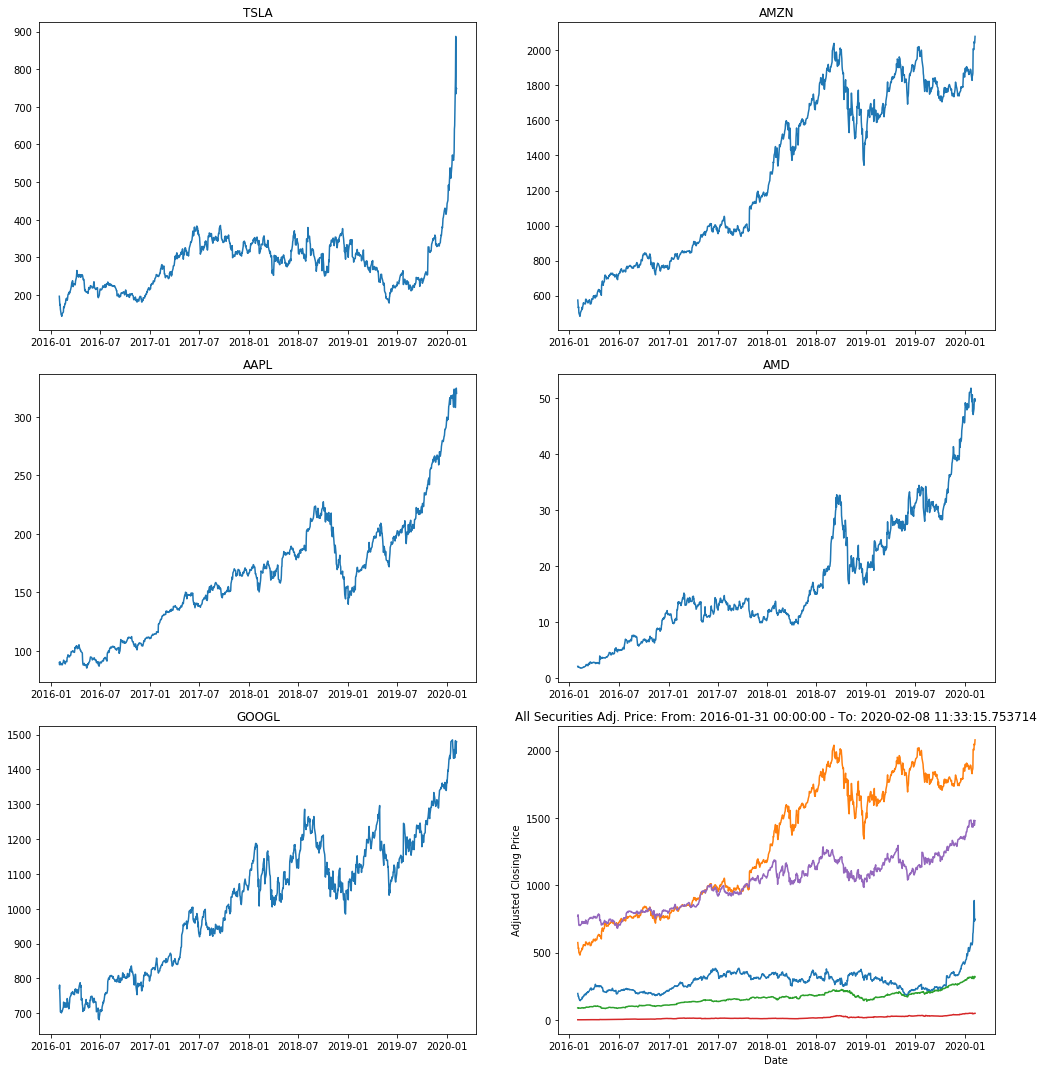

In [8]:
fig = plt.figure(figsize=(15,15))
ax1 = fig.add_subplot(321)
ax2 = fig.add_subplot(322)
ax3 = fig.add_subplot(323)
ax4 = fig.add_subplot(324)
ax5 = fig.add_subplot(325)
ax6 = fig.add_subplot(326)


#s_data = wb.DataReader([s1, s2, s3, s4, s5], 'yahoo', start, end)

ax1.plot(s_data['Adj Close'][s1])
ax1.set_title(s1)

ax2.plot(s_data['Adj Close'][s2])
ax2.set_title(s2)

ax3.plot(s_data['Adj Close'][s3])
ax3.set_title(s3)

ax4.plot(s_data['Adj Close'][s4])
ax4.set_title(s4)

ax5.plot(s_data['Adj Close'][s5])
ax5.set_title(s5)


ax6.plot(adj_close)
plt.xlabel('Date')
plt.ylabel('Adjusted Closing Price')
plt.title('All Securities Adj. Price: ' + date_span)

#ax6.set_title(stocks)

plt.tight_layout()
plt.show()

# LOGRITHMIC RATE OF RETURN
Log return is one of three methods for calculating return and it assumes returns are compounded continuously rather than across sub-periods. It is calculated by taking the natural log of the ending value divided by the beginning value. ( Using the LN on most calculators, or the =LN() function in Excel)

In [9]:
#  COMPUTE LOG RoR DAILY MEAN AVG:
# COMPUTING LOG RoR IN EACH ASSET'S DF-B

# . . . . . . . . . . . . . . . . . . . . . . . . . . ASSET = s1 (DF-B) . . . . . . . . . . . . . . . . . . . . . . . . . . 
df_1['log_return'] = np.log(df_1 / df_1.shift(1))
df_1_log = round(df_1['log_return'].mean() * 250, 4)
print('The Logrithmic RoR of '+s1+' = '+str(display_as_percentage(df_1_log)))
print('')

# . . . . . . . . . . . . . . . . . . . . . . . . . . ASSET = s2 (DF-B) . . . . . . . . . . . . . . . . . . . . . . . . . .
df_2['log_return'] = np.log(df_2 / df_2.shift(1))
df_2_log = round(df_2['log_return'].mean() * 250, 4)
print('The Logrithmic RoR of '+s2+' = '+str(display_as_percentage(df_2_log)))
print('')

# . . . . . . . . . . . . . . . . . . . . . . . . . . ASSET = s6 (DF-B) . . . . . . . . . . . . . . . . . . . . . . . . . .
df_3['log_return'] = np.log(df_3 / df_3.shift(1))
df_3_log = round(df_3['log_return'].mean() * 250, 4)
print('The Logrithmic RoR of '+s3+' = '+str(display_as_percentage(df_3_log)))
print('')

# . . . . . . . . . . . . . . . . . . . . . . . . . . ASSET = s4 (DF-B) . . . . . . . . . . . . . . . . . . . . . . . . . .
df_4['log_return'] = np.log(df_4 / df_4.shift(1))
df_4_log = round(df_4['log_return'].mean() * 250, 4)
print('The Logrithmic RoR of '+s4+' = '+str(display_as_percentage(df_4_log)))
print('')

# . . . . . . . . . . . . . . . . . . . . . . . . . . ASSET = s5 (DF-B) . . . . . . . . . . . . . . . . . . . . . . . . . .
df_5['log_return'] = np.log(df_5 / df_5.shift(1))
df_5_log = round(df_5['log_return'].mean() * 250, 4)
print('The Logrithmic RoR of '+s5+' = '+str(display_as_percentage(df_5_log)))
print('')


# . . . . . . . . . . . . . Generate New DataFrame To Create Bar Graph . . . . . . . . . . . . . . .

s_data_LOG_ror = pd.DataFrame(np.random.randn(1,5),index=['LOG_RoR',],columns=[s1,s2,s3,s4,s5])

s_data_LOG_ror[s1]=display_as_percentage(df_1_log)
s_data_LOG_ror[s2]=display_as_percentage(df_2_log)
s_data_LOG_ror[s3]=display_as_percentage(df_3_log)
s_data_LOG_ror[s4]=display_as_percentage(df_4_log)
s_data_LOG_ror[s5]=display_as_percentage(df_5_log)

s_data_LOG_ror

The Logrithmic RoR of TSLA = 33.0%

The Logrithmic RoR of AMZN = 31.8%

The Logrithmic RoR of AAPL = 31.4%

The Logrithmic RoR of AMD = 77.7%

The Logrithmic RoR of GOOGL = 16.1%



,TSLA,AMZN,AAPL,AMD,GOOGL
LOG_RoR,33.0%,31.8%,31.4%,77.7%,16.1%


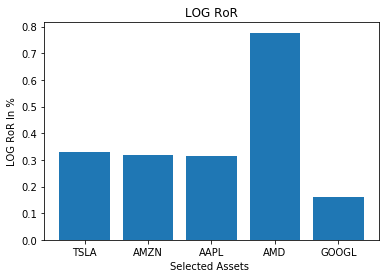

In [10]:
# . . . . . . . . . . . . . . . . . . BAR GRAPH LOG ROR . . . . . . . . . . . . . . . . . . 

stock_names=[s1,s2,s3,s4,s5]
stocks_LOG_ror=[df_1_log, df_2_log, df_3_log, df_4_log, df_5_log]

plt.bar(range(len(stock_names)),stocks_LOG_ror)
x_pos = np.arange(len(stock_names))

plt.xlabel('Selected Assets ')
plt.xticks(x_pos, stock_names)
plt.ylabel('LOG RoR In %')
plt.title('LOG RoR')

plt.show()

# SIMPLE RATE OF RETURN
The simple rate of return is the incremental amount of net income expected from a prospective investment opportunity, divided by the investment in it. ... A business would then accept a project if the measure yields a percentage that exceeds a certain hurdle rate used by the company as its minimum rate of return.

In [11]:
#  COMPUTE SIMPLE RoR AVG:
# COMPUTING SIMPLE RoR AVG IN EACH ASSET'S DF-B

# . . . . . . . . . . . . . . . . . . . . . . . . . . ASSET = s1 (DF-B) . . . . . . . . . . . . . . . . . . . . . . . . . . 
df_1['simple_return'] = (df_1['Adj Close'] / df_1['Adj Close'].shift(1)) - 1
s1_avg_ror = round(df_1['simple_return'].mean() * 250, 4)
print('The Simple RoR of ' + s1 + ' = ' + str(display_as_percentage(s1_avg_ror)))
print('')

# . . . . . . . . . . . . . . . . . . . . . . . . . . ASSET = s2 (DF-B) . . . . . . . . . . . . . . . . . . . . . . . . . .
df_2['simple_return'] = (df_2['Adj Close'] / df_2['Adj Close'].shift(1)) - 1
s2_avg_ror = round(df_2['simple_return'].mean() * 250, 4)
print('The Simple RoR of ' + s2 + ' = ' + str(display_as_percentage(s2_avg_ror)))
print('')

# . . . . . . . . . . . . . . . . . . . . . . . . . . ASSET = s6 (DF-B) . . . . . . . . . . . . . . . . . . . . . . . . . .
df_3['simple_return'] = (df_3['Adj Close'] / df_3['Adj Close'].shift(1)) - 1
s3_avg_ror = round(df_3['simple_return'].mean() * 250, 4)
print('The Simple RoR of ' + s3 + ' = ' + str(display_as_percentage(s3_avg_ror)))
print('')

# . . . . . . . . . . . . . . . . . . . . . . . . . . ASSET = s4 (DF-B) . . . . . . . . . . . . . . . . . . . . . . . . . .
df_4['simple_return'] = (df_4['Adj Close'] / df_4['Adj Close'].shift(1)) - 1
s4_avg_ror = round(df_4['simple_return'].mean() * 250, 4)
print('The Simple RoR of ' + s4 + ' = ' + str(display_as_percentage(s4_avg_ror)))
print('')

# . . . . . . . . . . . . . . . . . . . . . . . . . . ASSET = s5 (DF-B) . . . . . . . . . . . . . . . . . . . . . . . . . .
df_5['simple_return'] = (df_5['Adj Close'] / df_5['Adj Close'].shift(1)) - 1
s5_avg_ror = round(df_5['simple_return'].mean() * 250, 4)
print('The Simple RoR of ' + s5 + ' = ' + str(display_as_percentage(s5_avg_ror)))
print('')


# . . . . . . . . . . . . . Generate New DataFrame To Create Bar Graph . . . . . . . . . . . . . . .

s_data_simple_ror = pd.DataFrame(np.random.randn(1,5),index=['Simple_RoR',],columns=[s1,s2,s3,s4,s5])

s_data_simple_ror[s1]=display_as_percentage(s1_avg_ror)
s_data_simple_ror[s2]=display_as_percentage(s2_avg_ror)
s_data_simple_ror[s3]=display_as_percentage(s3_avg_ror)
s_data_simple_ror[s4]=display_as_percentage(s4_avg_ror)
s_data_simple_ror[s5]=display_as_percentage(s5_avg_ror)

s_data_simple_ror

The Simple RoR of TSLA = 44.9%

The Simple RoR of AMZN = 35.4%

The Simple RoR of AAPL = 34.2%

The Simple RoR of AMD = 97.7%

The Simple RoR of GOOGL = 18.5%



,TSLA,AMZN,AAPL,AMD,GOOGL
Simple_RoR,44.9%,35.4%,34.2%,97.7%,18.5%


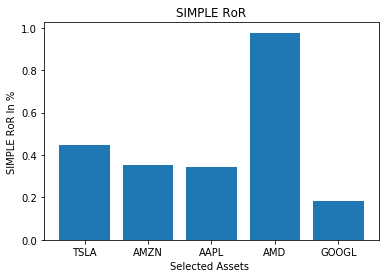

In [12]:
# . . . . . . . . . . . . . . . . . . BAR GRAPH SIMPLE ROR . . . . . . . . . . . . . . . . . . 

stock_names=[s1,s2,s3,s4,s5]
stocks_simple_ror=[s1_avg_ror, s2_avg_ror, s3_avg_ror, s4_avg_ror, s5_avg_ror]

plt.bar(range(len(stock_names)),stocks_simple_ror)
x_pos = np.arange(len(stock_names))

plt.xlabel('Selected Assets ')
plt.xticks(x_pos, stock_names)
plt.ylabel('SIMPLE RoR In %')
plt.title('SIMPLE RoR')

plt.show()

# DAILY MEAN RATE OF RETURN
Search Results
Featured snippet from the web
The daily return measures the dollar change in a stock's price as a percentage of the previous day's closing price. A positive return means the stock has grown in value, while a negative return means it has lost value.

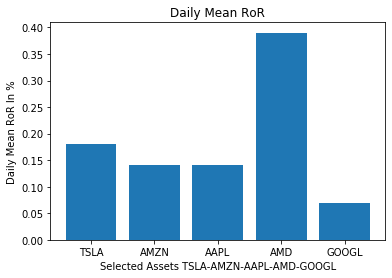

In [13]:
# . . . . . . . . . . . . . . . . . . . . . . . DAILY MEAN INDEX FOR X-AXIS . . . . . . . . . . . . . . . . . . . . . . .
s_data_returns = adj_close.pct_change()
stock_data_mean = round(s_data_returns.mean(),4) * 100
stock_data_mean.keys()

# . . . . . . . . . . . . . . . . . . . . . . . GRAB EACH DAILY MEAN VALUE FOR Y-AXIS . . . . . . . . . . . . . . . . . .
height = []
for key in stock_data_mean.keys():
    height.append(stock_data_mean[key])
height

# . . . . . . . . . . . . . . . . . . . . . . . ARRANGE KEYS ON X-AXIS BASED ON LENGTH . . . . . . . . . . . . . . . . . .
x_pos = np.arange(len(stock_data_mean.keys()))
x_pos

# . . . . . . . . . . . . . . . . . . . . . . . PLOT BARS . . . . . . . . . . . . . . . . . . . . . . .
plt.bar(x_pos, height)

# . . . . . . . . . . . . . . . . . . . . . . . CREATE NAME FOR X-AXIS . . . . . . . . . . . . . . . . . . . . . . .
plt.xticks(x_pos, stock_data_mean.keys())

# . . . . . . . . . . . . . . . . . . . . . . . LABEL CHART . . . . . . . . . . . . . . . . . . . . . . .
plt.xlabel('Selected Assets '+ s1 +'-'+ s2 +'-'+ s3 +'-'+ s4 +'-'+s5)
plt.ylabel('Daily Mean RoR In %')
plt.title('Daily Mean RoR')

# . . . . . . . . . . . . . . . . . . . . . . . SHOW CHART . . . . . . . . . . . . . . . . . . . . . . .
plt.show()

# VARIANCE
Variance (σ2) in statistics is a measurement of the spread between numbers in a data set. That is, it measures how far each number in the set is from the mean and therefore from every other number in the set.

KEY TAKEAWAYS

-In investing, variance is used to compare the relative performance of each asset in a portfolio.

-Because the results can be difficult to analyze, standard deviation is often used instead of variance.

-In either case, the goal for the investor is to improve asset allocation.

-Variance measures variability from the average or mean.

In [14]:
# calculate variance
daily_var = round(s_data_returns.var(),5)*100
daily_var

Symbols
TSLA     0.096
AMZN     0.029
AAPL     0.023
AMD      0.166
GOOGL    0.019
dtype: float64

Index(['TSLA', 'AMZN', 'AAPL', 'AMD', 'GOOGL'], dtype='object', name='Symbols')
[0.096, 0.029, 0.023, 0.166, 0.019]
[0 1 2 3 4]


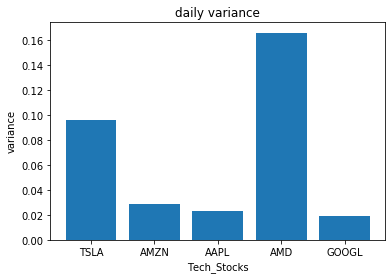

In [15]:
# variance index for the x axis
daily_var.keys()
print(daily_var.keys())

# grab each variance value for the y axis
height = []
for key in daily_var.keys():
    height.append(daily_var[key])
height
print(height)

# arrange keys on x axis based on length
x_pos = np.arange(len(daily_var.keys()))
x_pos
print(x_pos)

# plot bars
plt.bar(x_pos, height)
 
# create names on the x-axis
plt.xticks(x_pos, daily_var.keys())

# label chart
plt.xlabel("Tech_Stocks")
plt.ylabel("variance")
plt.title("daily variance")

# show graphic
plt.show()

# STANDARD DEVIATION

The standard deviation is a statistic that measures the dispersion of a dataset relative to its mean and is calculated as the square root of the variance. It is calculated as the square root of variance by determining the variation between each data point relative to the mean. If the data points are further from the mean, there is a higher deviation within the data set; thus, the more spread out the data, the higher the standard deviation.


Standard deviation is a statistical measurement in finance that, when applied to the annual rate of return of an investment, sheds light on the historical volatility of that investment. The greater the standard deviation of securities, the greater the variance between each price and the mean, which shows a larger price range. For example, a volatile stock has a high standard deviation, while the deviation of a stable blue-chip stock is usually rather low.

KEY TAKEAWAYS

-Standard deviation measures the dispersion of a dataset relative to its mean.

-A volatile stock has a high standard deviation, while the deviation of a stable blue-chip stock is usually rather low.

-As a downside, it calculates all uncertainty as risk, even when it’s in the investor's favor—such as above average returns.

In [16]:
# calculate standard deviation
daily_std = s_data_returns.std()

for i in daily_std:
    print(display_as_percentage(i))



3.1%
1.7%
1.5%
4.1%
1.4%


Index(['TSLA', 'AMZN', 'AAPL', 'AMD', 'GOOGL'], dtype='object', name='Symbols')
[0.030917100123449833, 0.01706103989890904, 0.01507338657709997, 0.04070017926605186, 0.013922942673081177]
[0 1 2 3 4]


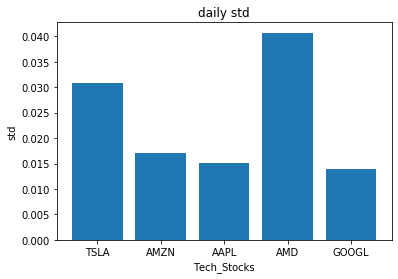

In [17]:
# standard deviation index for the x axis
daily_var.keys()
print(daily_var.keys())

# grab each standard deviation value for the y axis
height = []
for key in daily_std.keys():
    height.append(daily_std[key])
height
print(height)

# arrange keys on x axis based on length
x_pos = np.arange(len(daily_std.keys()))
x_pos
print(x_pos)

# plot bars
plt.bar(x_pos, height)
 
# create names on the x-axis
plt.xticks(x_pos, daily_std.keys())

# label chart
plt.xlabel("Tech_Stocks")
plt.ylabel("std")
plt.title("daily std")

# show graphic
plt.show()

# CORRELATION

What Is the Correlation Coefficient?
The correlation coefficient is a statistical measure that calculates the strength of the relationship between the relative movements of two variables. The values range between -1.0 and 1.0. A calculated number greater than 1.0 or less than -1.0 means that there was an error in the correlation measurement. A correlation of -1.0 shows a perfect negative correlation, while a correlation of 1.0 shows a perfect positive correlation. A correlation of 0.0 shows no relationship between the movement of the two variables.


Correlation statistics can be used in finance and investing. For example, a correlation coefficient could be calculated to determine the level of correlation between the price of crude oil and the stock price of an oil-producing company, such as Exxon Mobil Corporation. Since oil companies earn greater profits as oil prices rise, the correlation between the two variables is highly positive.

KEY TAKEAWAYS

-Correlation coefficients are used to measure the strength of the relationship between two variables.

-Pearson correlation is the one most commonly used in statistics. This measures the strength and direction of a linear relationship between two variables.

-Values always range between -1 (strong negative relationship) and +1 (strong positive relationship). Values at or close to zero imply weak or no relationship.

-Correlation coefficient values less than +0.8 or greater than -0.8 are not considered significant.

In [18]:
s_data_returns.corr()

Symbols,TSLA,AMZN,AAPL,AMD,GOOGL
Symbols,,,,,
TSLA,1.000000,0.299196,0.283523,0.234214,0.276364
AMZN,0.299196,1.000000,0.530891,0.317086,0.646700
AAPL,0.283523,0.530891,1.000000,0.323447,0.566349
AMD,0.234214,0.317086,0.323447,1.000000,0.251432
GOOGL,0.276364,0.646700,0.566349,0.251432,1.000000
